In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import time


In [33]:
np.random.randint(0,1)

0

In [2]:
class Near():
    def __init__(self, path=None):
        
        opt_option = {
                'verbose': False,
                'ipopt.tol': 1e-2,
                'ipopt.acceptable_tol': 1e-2,
                'ipopt.max_iter': 20,
                # 'ipopt.warm_start_init_point': 'yes',
                'ipopt.print_level': 0,
            }

        if path==None:
            t = ca.SX.sym('t')
            traj_ploy = ca.SX.sym("traj_ploy", 12, 2)
            dts = ca.SX.sym("dts",2)
            pos = ca.SX.sym('pos', 3)

            obj = (self.traj_ploy(traj_ploy, dts, t)-pos).T@(self.traj_ploy(traj_ploy, dts, t)-pos)

            nlp_dect = {
                'f': obj,
                'x': t,
                'p': ca.vertcat(traj_ploy[:,0], traj_ploy[:,1], dts, pos)
            }
            self._opt_solver = ca.nlpsol('opt', 'ipopt', nlp_dect, opt_option)
        else:
            self._opt_solver = ca.nlpsol('opt', 'ipopt', path, opt_option)

    def solve(self, coef1, coef2, dt1, dt2, pos):
        p = np.zeros(12*2+2+3)
        p[:12] = coef1
        p[12:24] = coef2
        p[24] = dt1
        p[25] = dt2
        p[26:] = pos

        res = self._opt_solver(
            x0=0,
            p=p
        )

        return res['x'].full().flatten()


    def traj_ploy(self, ploy_coef, dts, t):
        p=0

        a0=ploy_coef[:3,0]
        a1=ploy_coef[3:6,0]
        a2=ploy_coef[6:9,0]
        a3=ploy_coef[9:12,0]
        dt = dts[0]+t
        dtdt = dt*dt
        dtdtdt = dtdt*dt
        p+= (t<=0)*( a0+a1*dt+a2*dtdt+a3*dtdtdt )
        
        a0=ploy_coef[:3,1]
        a1=ploy_coef[3:6,1]
        a2=ploy_coef[6:9,1]
        a3=ploy_coef[9:12,1]
        dt = t
        dtdt = dt*dt
        dtdtdt = dtdt*dt
        p+= (t>0)*( a0+a1*dt+a2*dtdt+a3*dtdtdt )

        return p

In [48]:
from trajectory import Trajectory

traj = Trajectory("./results/res_t_n8.csv", near_path="./generated/near.so")
traj._pos

array([[-5.99138145, -2.00033162, -2.20506168],
       [-6.00754515, -1.81512645, -2.30761251],
       [-5.97538788, -1.6334608 , -2.41308567],
       [-5.89587599, -1.45522369, -2.52045875],
       [-5.76995826, -1.28026713, -2.62873021],
       [-5.59856783, -1.10840741, -2.73691998],
       [-5.38262409, -0.93942664, -2.84407012],
       [-5.12303434, -0.77307409, -2.94924537],
       [-4.82069547, -0.6090677 , -3.05153383],
       [-4.47649551, -0.44709549, -3.1500475 ],
       [-4.09131502, -0.28681703, -3.24392296],
       [-3.66602851, -0.1278649 , -3.33232187],
       [-3.20150589,  0.03015383, -3.41443147],
       [-2.70090324,  0.18743312, -3.48803991],
       [-2.16353319,  0.34455843, -3.5533727 ],
       [-1.58769355,  0.50340751, -3.6067151 ],
       [-0.97257047,  0.66631705, -3.6425448 ],
       [-0.31810156,  0.83567248, -3.65537557],
       [ 0.3750331 ,  1.01387515, -3.63983071],
       [ 1.09846622,  1.20133803, -3.59020883],
       [ 1.68608929,  1.35620406, -3.520

0.0016748905181884766


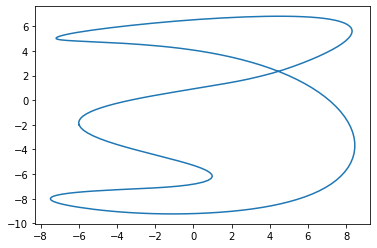

In [81]:
plt.plot(traj._pos[:,0], traj._pos[:,1])
t1 = time.time()
# p,v = traj.sample_dt(10, np.array([-5, 2.00033162, 2.20506168]), 0.1)
traj.sample(30,np.array([-5, 2.00033162, 2.20506168]))
t2 = time.time()
print(t2-t1)
# plt.scatter(p[:,0], p[:,1])

In [113]:
nn = Near("./generated/near.so")
# nn = Near()
nn.solve(traj._ploynomials[0], traj._ploynomials[1], traj._dt[0], traj._dt[1], np.array([-6., -1.8, -2]))

         opt  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  21.00us (  7.00us)  17.63us (  5.88us)         3
    nlp_grad  |   7.00us (  7.00us)   6.41us (  6.41us)         1
  nlp_grad_f  |  20.00us (  5.00us)  17.83us (  4.46us)         4
  nlp_hess_l  |   7.00us (  3.50us)   7.22us (  3.61us)         2
       total  |   2.17ms (  2.17ms)   2.16ms (  2.16ms)         1


array([-0.03987776])

In [67]:
nn._opt_solver.generate_dependencies('near.c')

'near.c'

In [ ]:
# Quaternion Multiplication
def quat_mult(q1,q2):
    ans = ca.vertcat(q2[0,:] * q1[0,:] - q2[1,:] * q1[1,:] - q2[2,:] * q1[2,:] - q2[3,:] * q1[3,:],
           q2[0,:] * q1[1,:] + q2[1,:] * q1[0,:] - q2[2,:] * q1[3,:] + q2[3,:] * q1[2,:],
           q2[0,:] * q1[2,:] + q2[2,:] * q1[0,:] + q2[1,:] * q1[3,:] - q2[3,:] * q1[1,:],
           q2[0,:] * q1[3,:] - q2[1,:] * q1[2,:] + q2[2,:] * q1[1,:] + q2[3,:] * q1[0,:])
    return ans

# Quaternion-Vector Rotation
def rotate_quat(q1,v1):
    ans = quat_mult(quat_mult(q1, ca.vertcat(0, v1)), ca.vertcat(q1[0,:],-q1[1,:], -q1[2,:], -q1[3,:]))
    return ca.vertcat(ans[1,:], ans[2,:], ans[3,:]) # to covert to 3x1 vec

In [3]:
def ploynomial(p1, p2, v1, v2, dt):
     a0 = p1
     a1 = v1
     a2 = (3*p2-3*p1-2*v1*dt-v2*dt)/dt/dt
     a3 = (2*p1-2*p2+v2*dt+v1*dt)/dt/dt/dt

     return a0, a1, a2, a3

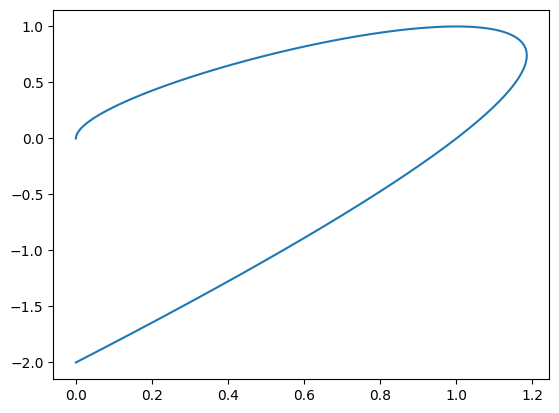

In [37]:
p1 = np.array([[0],[0]])
p2 = np.array([[1],[1]])
v1 = np.array([[0],[1]])
v2 = np.array([[1],[0]])
dt = 1

a0, a1, a2, a3 = ploynomial(p1, p2, v1, v2, dt)

t = np.linspace(0,2,100,endpoint=True)

p = a0+a1*t+a2*t*t+a3*t*t*t

plt.plot(p[0,:],p[1,:])

In [10]:
a0 = np.array([1,2,3])
a1 = np.array([4,5,6])
np.concatenate([a0,a1])

array([1, 2, 3, 4, 5, 6])

In [23]:
a = [1,2,3,4,5,6]

TypeError: slice indices must be integers or None or have an __index__ method

nan